# CTPN

In [59]:
from __future__ import print_function

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from lib.fast_rcnn.config import cfg, cfg_from_file
from lib.fast_rcnn.test import _get_blobs
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg
from lib.rpn_msr.proposal_layer_tf import proposal_layer

def resize_im(im, scale, max_scale=None):
    f = float(scale) / min(im.shape[0], im.shape[1])
    if max_scale != None and f * max(im.shape[0], im.shape[1]) > max_scale:
        f = float(max_scale) / max(im.shape[0], im.shape[1])
    return cv2.resize(im, None, None, fx=f, fy=f, interpolation=cv2.INTER_LINEAR), f


def draw_boxes(img, image_name, boxes, scale, bbox):
    for box in boxes:
        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
            continue
        if box[8] >= 0.9:
            color = (0, 255, 0)
        elif box[8] >= 0.8:
            color = (255, 0, 0)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[4]), int(box[5])), color, 2)
        cv2.line(img, (int(box[6]), int(box[7])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[4]), int(box[5])), (int(box[6]), int(box[7])), color, 2)

        min_x = min(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        min_y = min(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        max_x = max(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        max_y = max(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        
        bbox.append([min_x, min_y, max_x, max_y])

    img = cv2.resize(img, None, None, fx=1.0 / scale, fy=1.0 / scale, interpolation=cv2.INTER_LINEAR)

In [60]:
cfg_from_file('ctpn/text.yml')

# init session
config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=config)
with gfile.FastGFile('data/ctpn.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
sess.run(tf.global_variables_initializer())

input_img = sess.graph.get_tensor_by_name('Placeholder:0')
output_cls_prob = sess.graph.get_tensor_by_name('Reshape_2:0')
output_box_pred = sess.graph.get_tensor_by_name('rpn_bbox_pred/Reshape_1:0')

In [61]:
im_name = "data/demo/TP.jpg"
img = cv2.imread(im_name)
img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
blobs, im_scales = _get_blobs(img, None)
if cfg.TEST.HAS_RPN:
    im_blob = blobs['data']
    blobs['im_info'] = np.array(
        [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
        dtype=np.float32)
cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

scores = rois[:, 0]
boxes = rois[:, 1:5] / im_scales[0]
textdetector = TextDetector()
boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
bbox = []
draw_boxes(img, im_name, boxes, scale, bbox)

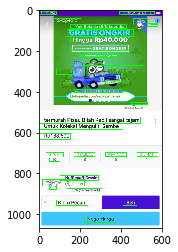

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline  

# draw image
plt.figure()
plt.imshow(img)

In [63]:
imgs = []
img = cv2.imread(im_name)
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    crop_img = img[x1:x2, y1:y2]
#     crop_img = cv2.resize(crop_img, None, fx = 2, fy = 2.4, interpolation = cv2.INTER_CUBIC)
    # gaussian_3 = cv2.GaussianBlur(crop_img, (9,9), 10.0)
    # unsharp_image = cv2.addWeighted(crop_img, 1.5, gaussian_3, -0.5, 0, crop_img)

    # blurred_f = ndimage.gaussian_filter(crop_img, 3)
    # filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
    # alpha = 5
    # sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    imgs.append(crop_img)

In [64]:
# ga tahu kenapa di notebook ada beberapa warna yang berubah

# for i in imgs :
#     plt.figure()
#     plt.imshow(i)

# Tesseract

### Without processing

In [65]:
import pandas as pd
import tesserocr
from PIL import Image

/home/mhilmiasyrofi/tensorflow-cpu/venv/local/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


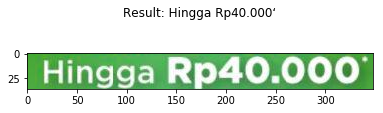

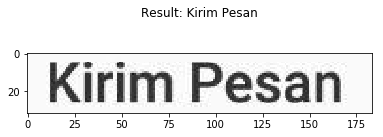

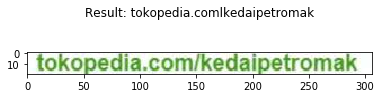

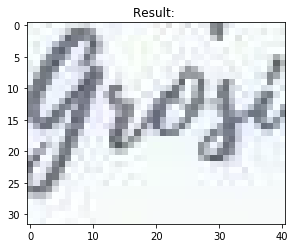

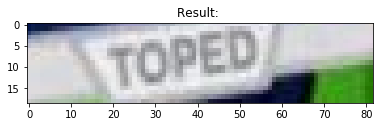

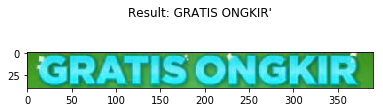

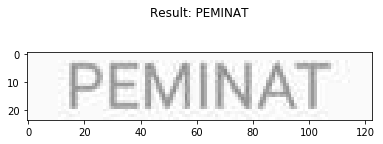

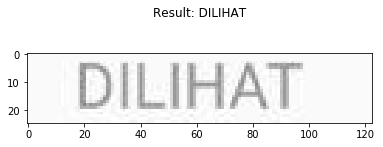

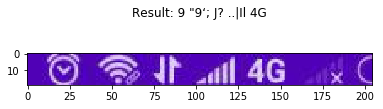

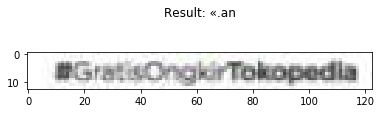

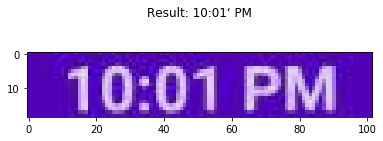

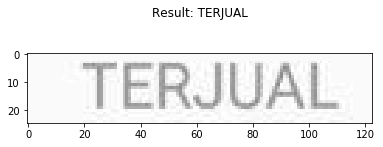

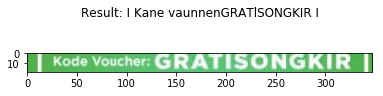

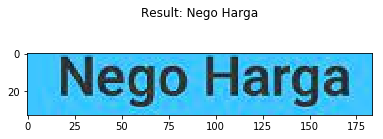

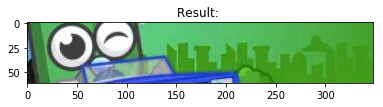

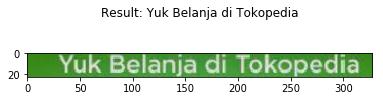

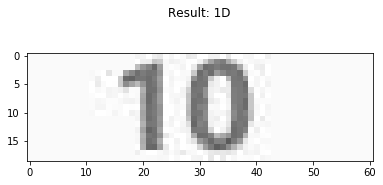

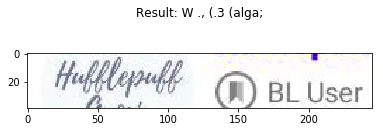

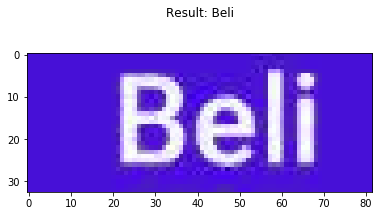

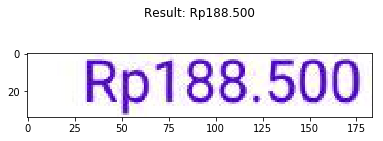

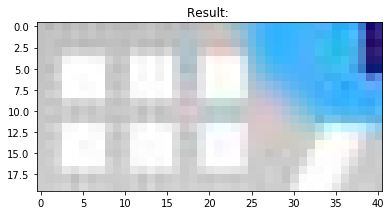

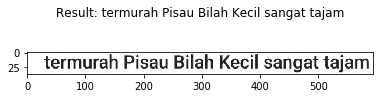

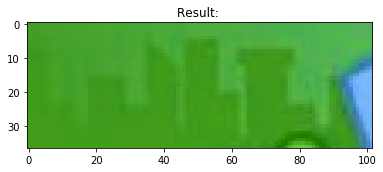

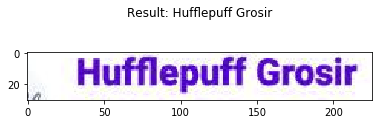

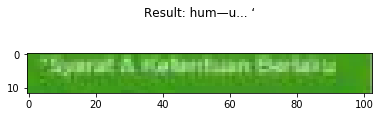

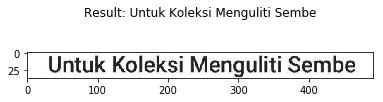

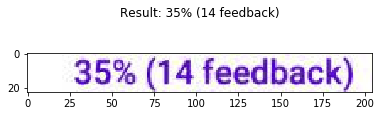

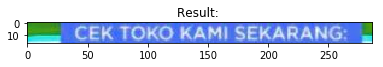

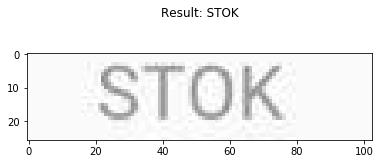

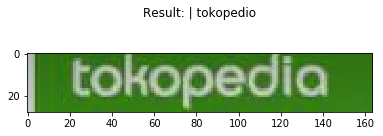

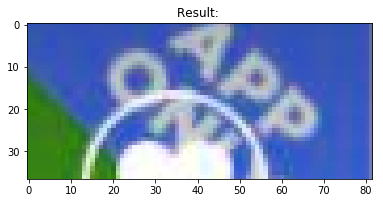

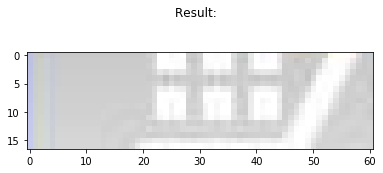

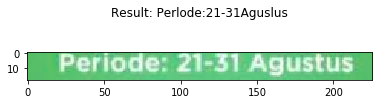

In [66]:
# print(tesserocr.tesseract_version())  # print tesseract-ocr version
# print(tesserocr.get_languages())  # prints tessdata path and list of available languages

texts = []

for img in imgs :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)
    texts.append(text)
    


## Resampling

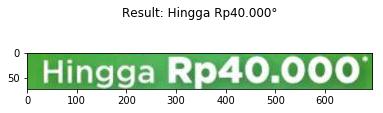

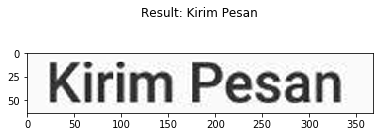

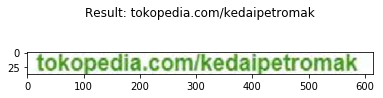

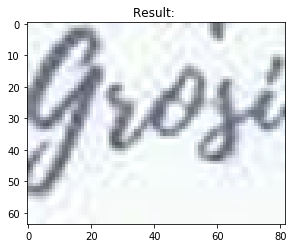

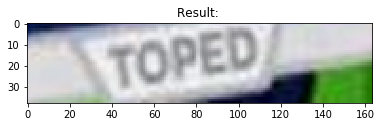

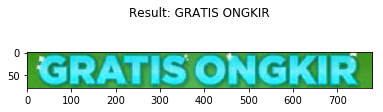

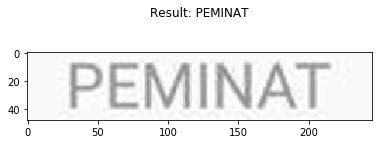

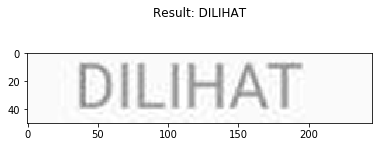

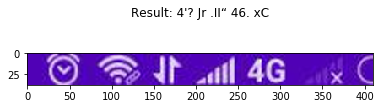

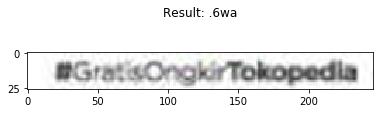

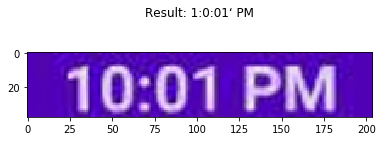

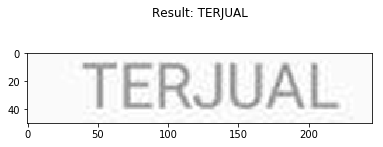

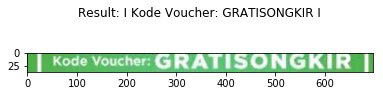

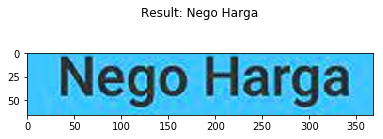

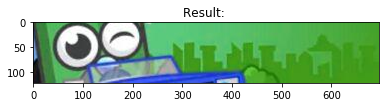

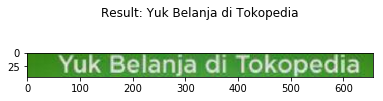

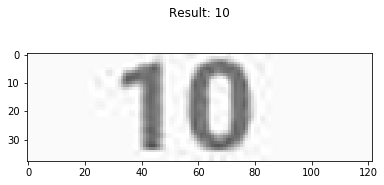

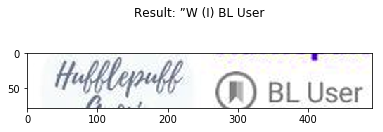

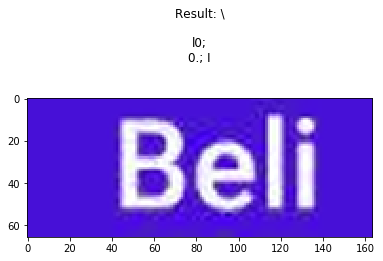

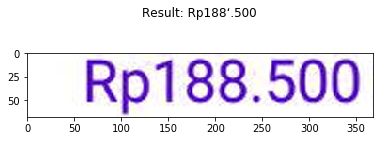

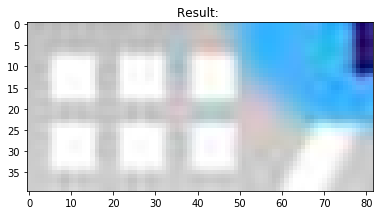

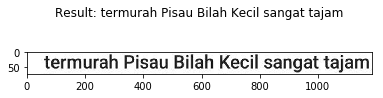

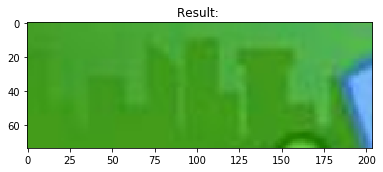

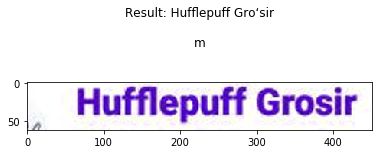

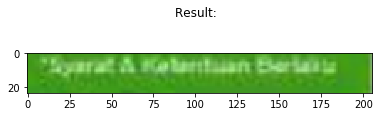

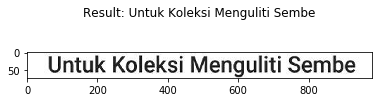

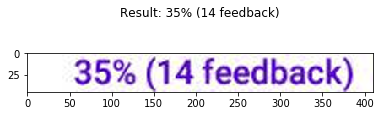

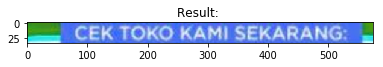

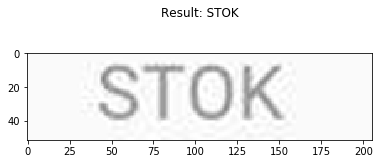

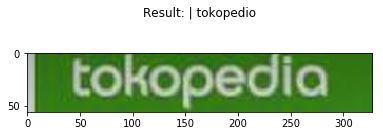

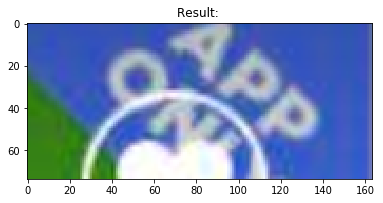

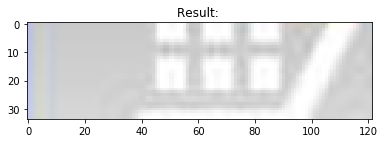

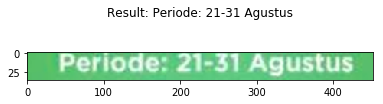

In [67]:
imgs_copy = imgs
for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)


## Resampling  + Unsharp

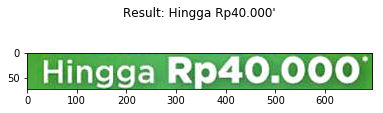

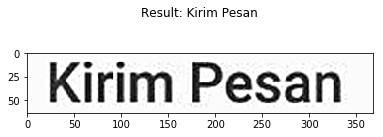

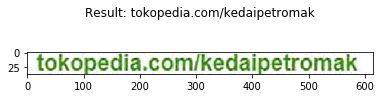

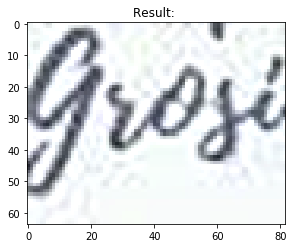

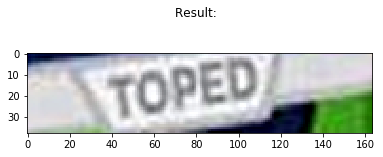

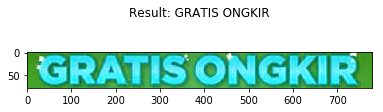

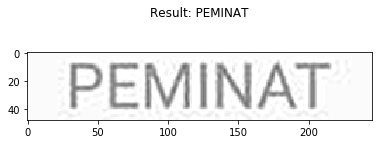

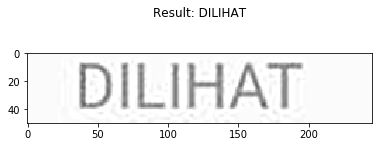

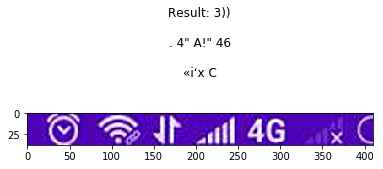

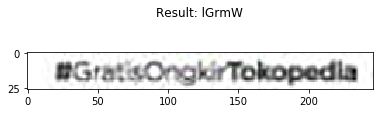

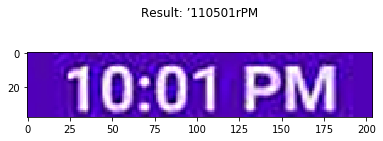

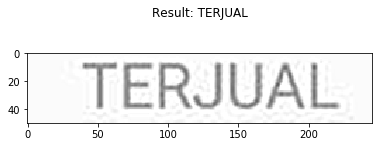

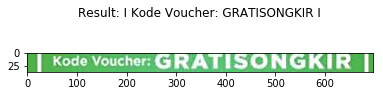

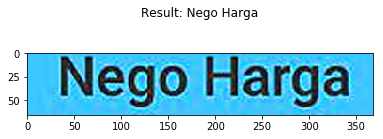

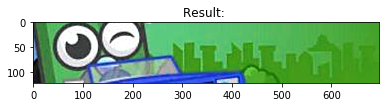

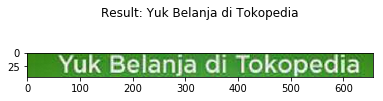

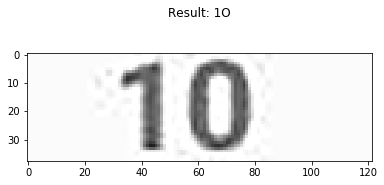

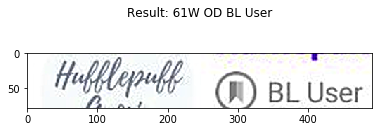

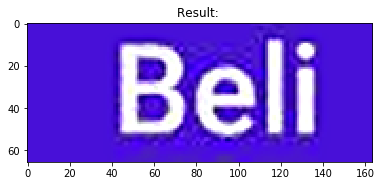

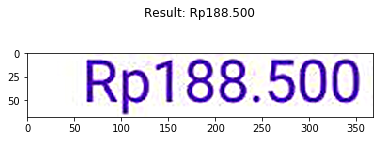

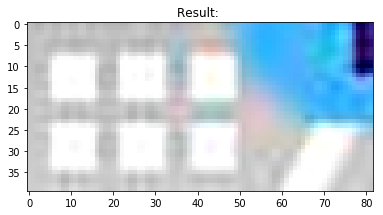

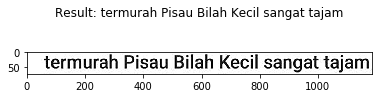

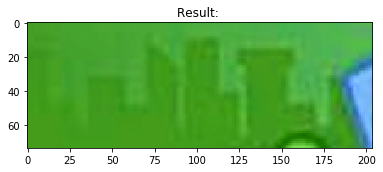

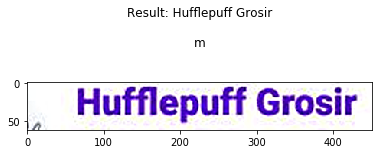

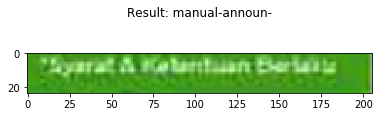

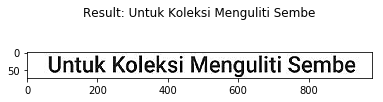

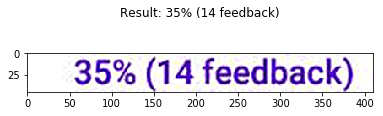

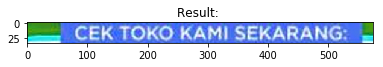

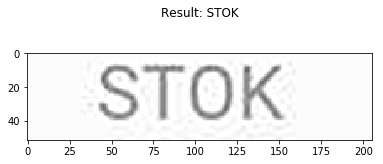

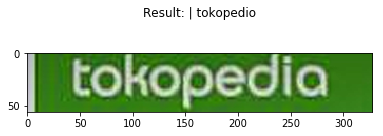

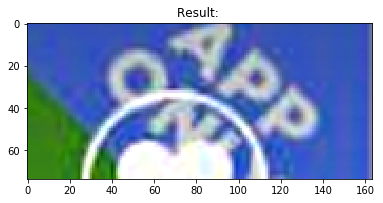

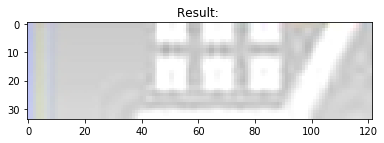

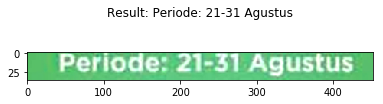

In [68]:
imgs_copy = imgs
for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0)
    unsharp_image = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)


## Binarisation

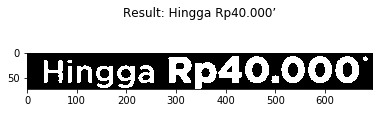

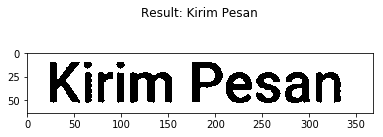

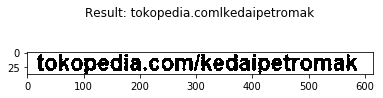

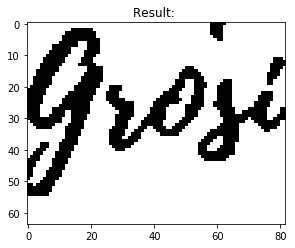

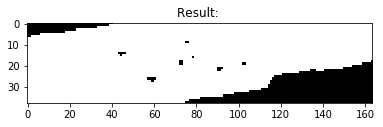

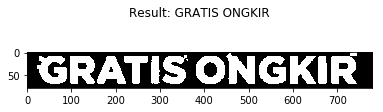

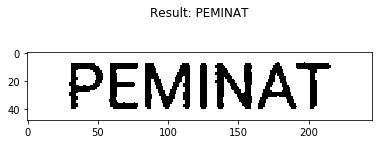

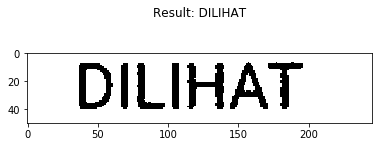

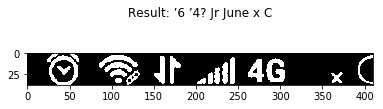

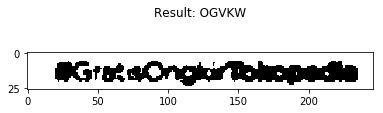

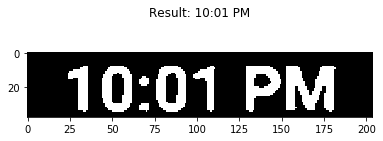

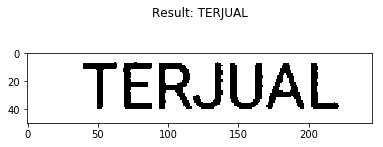

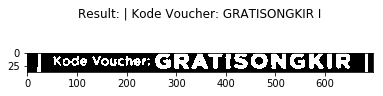

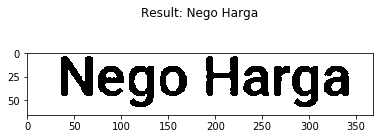

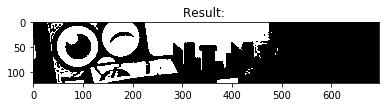

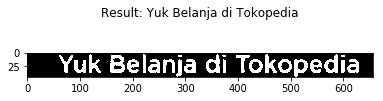

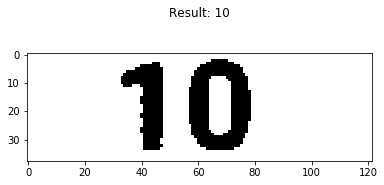

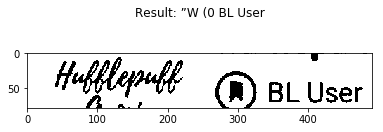

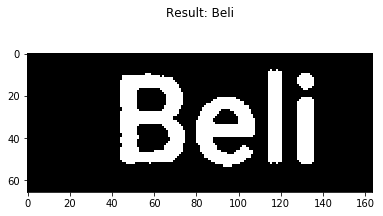

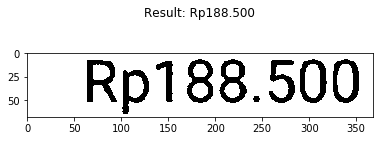

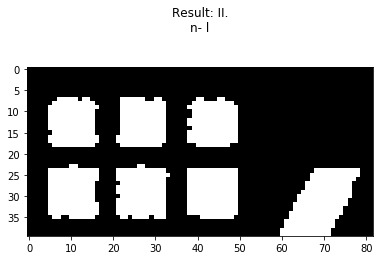

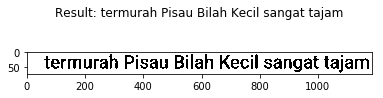

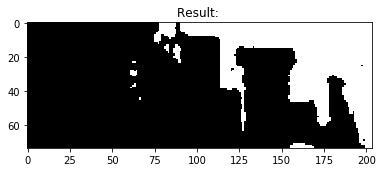

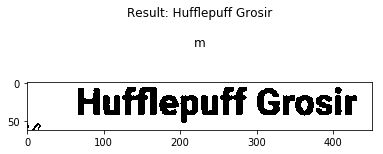

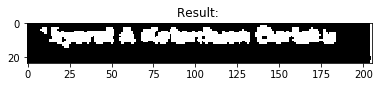

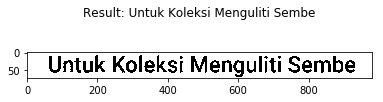

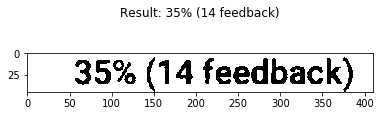

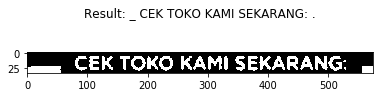

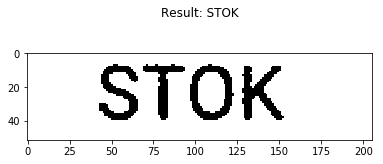

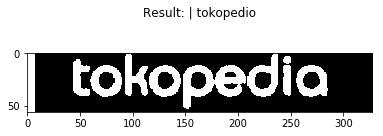

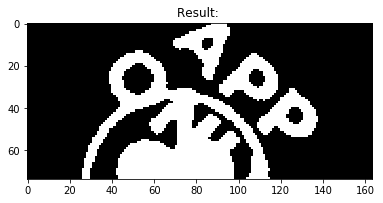

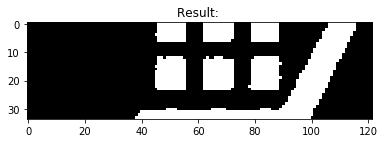

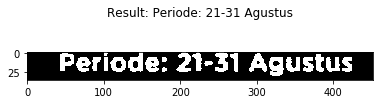

In [69]:
imgs_copy = imgs
for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)

## Median Blur

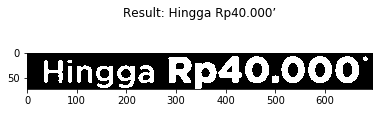

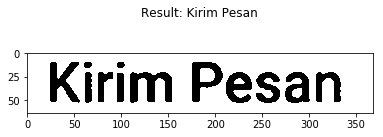

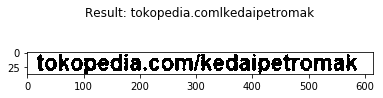

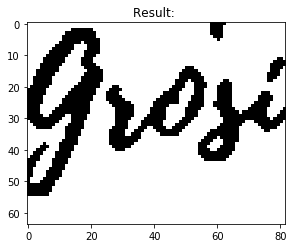

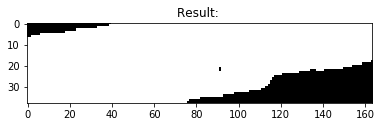

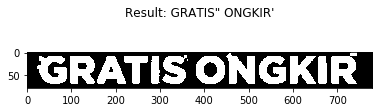

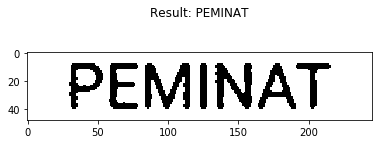

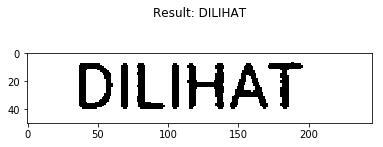

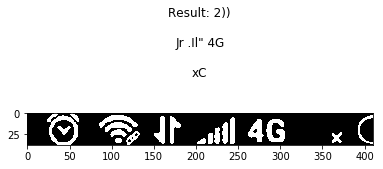

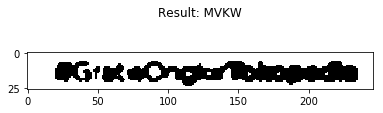

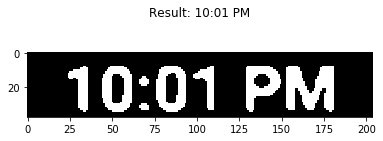

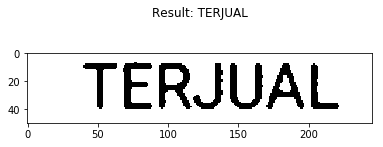

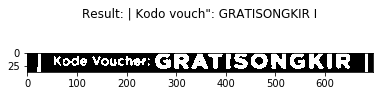

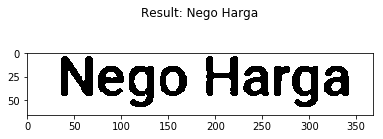

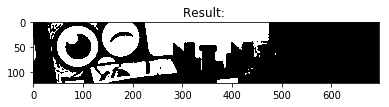

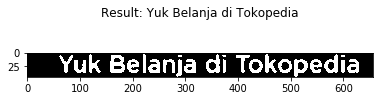

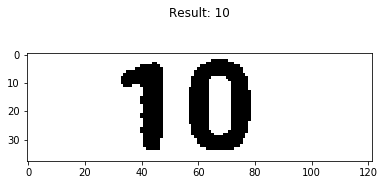

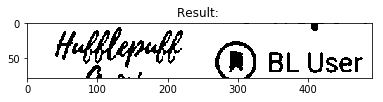

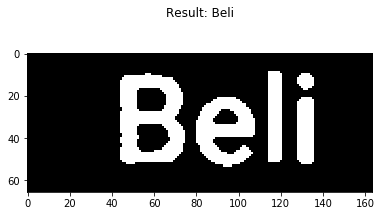

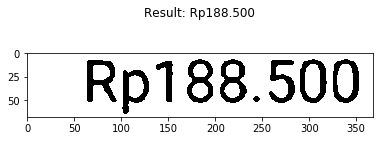

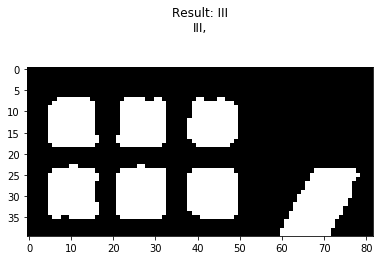

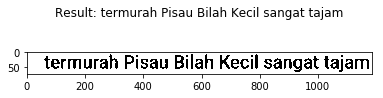

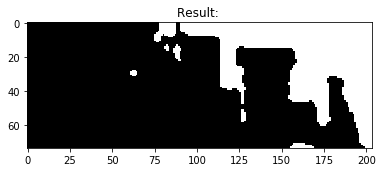

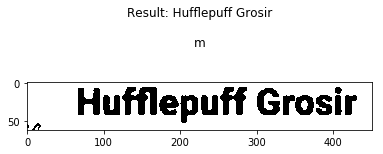

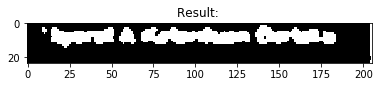

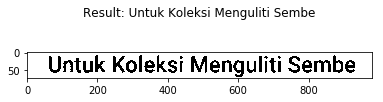

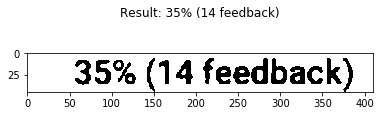

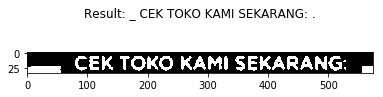

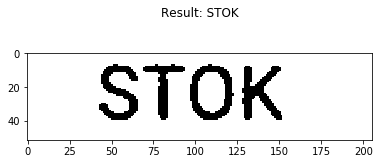

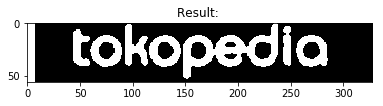

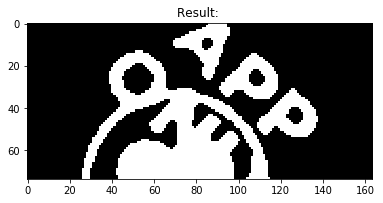

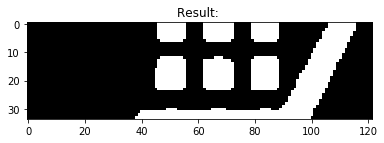

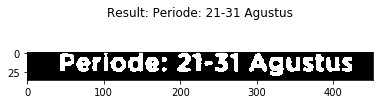

In [70]:
imgs_copy = imgs
for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img = cv2.medianBlur(img, 3)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)